# 第7章补充：归一化变种与残差连接

> **学习目标：**
> - 理解Layer Normalization、Group Normalization等归一化变种
> - 深入理解残差连接（ResNet）的原理和重要性
> - 了解DenseNet的密集连接思想
> - 掌握One Cycle学习率策略
>
> **前置知识：** 07_batch_norm_dropout.ipynb 的内容
>
> **学习时间：** 3-4小时

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',
    'PingFang SC',
    'STHeiti',
    'Heiti TC',
    'SimHei',
]
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成！")

环境配置完成！


---

## 1. 归一化方法概述

### 1.1 为什么需要不同的归一化方法？

**Batch Normalization的局限性：**
1. 依赖batch size：小batch时统计量不稳定
2. 训练/推理不一致：需要维护running statistics
3. 不适合序列数据：RNN/Transformer中batch维度含义不同

### 1.2 归一化方法分类

| 方法 | 归一化维度 | 适用场景 |
|------|-----------|----------|
| Batch Norm | 跨batch样本 | CNN（大batch） |
| Layer Norm | 跨特征维度 | Transformer、RNN |
| Instance Norm | 每个样本的每个通道 | 风格迁移 |
| Group Norm | 每个样本的通道组 | CNN（小batch） |

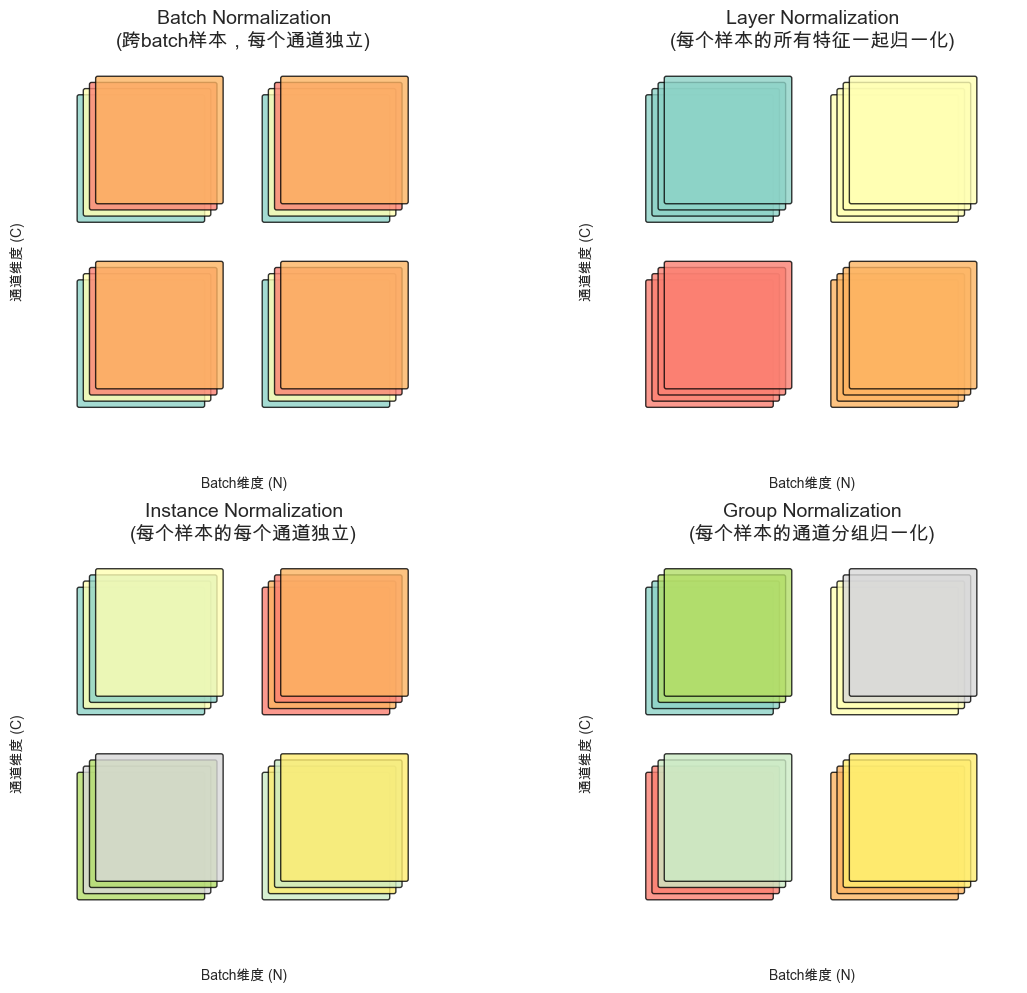


不同归一化方法的归一化范围：
- Batch Norm: μ, σ 在 (N, H, W) 维度计算，每个通道独立
- Layer Norm: μ, σ 在 (C, H, W) 维度计算，每个样本独立
- Instance Norm: μ, σ 在 (H, W) 维度计算，每个(样本,通道)独立
- Group Norm: μ, σ 在 (C/G, H, W) 维度计算，每个样本的每组独立


In [2]:
def visualize_normalization_types():
    """
    可视化不同归一化方法的作用范围
    
    假设输入张量形状为 (N, C, H, W)：
    - N: batch size
    - C: 通道数
    - H, W: 空间维度
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 颜色映射
    colors = plt.cm.Set3(np.linspace(0, 1, 8))
    
    def draw_cube(ax, title, highlight_fn):
        """
        绘制一个3D立方体表示，展示归一化的作用范围
        """
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # 绘制4个batch样本（2x2网格），每个样本有4个通道
        batch_positions = [(1, 6), (5.5, 6), (1, 1.5), (5.5, 1.5)]  # N=4
        
        for n, (bx, by) in enumerate(batch_positions):
            for c in range(4):  # C=4
                # 偏移以显示通道
                offset = c * 0.15
                x = bx + offset
                y = by + offset
                
                # 根据归一化类型决定颜色
                color = highlight_fn(n, c)
                
                rect = FancyBboxPatch((x, y), 3, 3, 
                                       boxstyle="round,pad=0.05",
                                       facecolor=color, edgecolor='black',
                                       linewidth=1, alpha=0.8)
                ax.add_patch(rect)
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # 添加轴标签
        ax.text(5, -0.5, 'Batch维度 (N)', ha='center', fontsize=10)
        ax.text(-0.5, 5, '通道维度 (C)', ha='center', va='center', 
                rotation=90, fontsize=10)
    
    # Batch Norm: 同一颜色跨所有batch样本的同一通道
    def bn_color(n, c):
        return colors[c]  # 每个通道一个颜色
    
    draw_cube(axes[0, 0], 'Batch Normalization\n(跨batch样本，每个通道独立)', bn_color)
    
    # Layer Norm: 同一颜色是每个样本的所有通道
    def ln_color(n, c):
        return colors[n]  # 每个样本一个颜色
    
    draw_cube(axes[0, 1], 'Layer Normalization\n(每个样本的所有特征一起归一化)', ln_color)
    
    # Instance Norm: 每个样本的每个通道独立
    def in_color(n, c):
        return colors[n * 2 + c % 2]  # 每个(样本,通道)对一个颜色
    
    draw_cube(axes[1, 0], 'Instance Normalization\n(每个样本的每个通道独立)', in_color)
    
    # Group Norm: 每个样本的通道分组
    def gn_color(n, c):
        group = c // 2  # 2个通道一组
        return colors[n + group * 4]
    
    draw_cube(axes[1, 1], 'Group Normalization\n(每个样本的通道分组归一化)', gn_color)
    
    plt.tight_layout()
    plt.show()
    
    print("\n不同归一化方法的归一化范围：")
    print("- Batch Norm: μ, σ 在 (N, H, W) 维度计算，每个通道独立")
    print("- Layer Norm: μ, σ 在 (C, H, W) 维度计算，每个样本独立")
    print("- Instance Norm: μ, σ 在 (H, W) 维度计算，每个(样本,通道)独立")
    print("- Group Norm: μ, σ 在 (C/G, H, W) 维度计算，每个样本的每组独立")

visualize_normalization_types()

---

## 2. Layer Normalization

### 2.1 Layer Norm原理

Layer Normalization在**每个样本的所有特征**上计算均值和方差：

$$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$$

$$y_i = \gamma \hat{x}_i + \beta$$

其中 $\mu$ 和 $\sigma^2$ 是对单个样本的所有特征计算的。

**与Batch Norm的关键区别：**
- Batch Norm：跨batch样本计算统计量
- Layer Norm：在每个样本内部计算统计量

In [3]:
class LayerNorm:
    """
    Layer Normalization - 从零实现
    
    论文: "Layer Normalization" (Ba et al., 2016)
    
    核心思想:
        对每个样本的所有特征进行归一化
        不依赖batch size，训练和推理时行为一致
    
    典型应用:
        - Transformer模型
        - 循环神经网络(RNN/LSTM)
    """
    
    def __init__(self, normalized_shape, eps=1e-5):
        """
        初始化Layer Normalization
        
        参数:
            normalized_shape: int或tuple，要归一化的特征维度
                对于(batch, seq_len, hidden)的输入，通常设为hidden
            eps: float，数值稳定性常数
        """
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = normalized_shape
        self.eps = eps
        
        # 可学习参数
        self.gamma = np.ones(normalized_shape)  # 缩放参数
        self.beta = np.zeros(normalized_shape)  # 平移参数
        
        # 缓存（用于反向传播）
        self.cache = None
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: numpy数组，输入
               对于Transformer: shape (batch, seq_len, hidden)
               对于全连接层: shape (batch, features)
        
        返回:
            归一化后的输出
        
        计算步骤:
            1. 计算每个样本在归一化维度上的均值和方差
            2. 归一化
            3. 缩放和平移
        """
        # 确定归一化的轴（最后几个维度）
        # 例如对于(batch, seq, hidden)，如果normalized_shape=(hidden,)
        # 则axis=(-1,)，只在hidden维度归一化
        n_dims = len(self.normalized_shape)
        axis = tuple(range(-n_dims, 0))  # 例如(-1,)或(-2,-1)
        
        # 计算均值和方差（每个样本独立计算）
        # keepdims=True保持维度以便广播
        mean = np.mean(x, axis=axis, keepdims=True)
        var = np.var(x, axis=axis, keepdims=True)
        
        # 归一化
        x_norm = (x - mean) / np.sqrt(var + self.eps)
        
        # 缩放和平移
        out = self.gamma * x_norm + self.beta
        
        # 缓存用于反向传播
        self.cache = (x, x_norm, mean, var)
        
        return out
    
    def backward(self, dout):
        """
        反向传播
        
        参数:
            dout: 上游梯度
        
        返回:
            dx: 输入的梯度
        """
        x, x_norm, mean, var = self.cache
        n_dims = len(self.normalized_shape)
        axis = tuple(range(-n_dims, 0))
        
        # 计算γ和β的梯度
        # 需要在batch和序列维度上求和
        sum_axis = tuple(range(len(x.shape) - n_dims))
        self.dgamma = np.sum(dout * x_norm, axis=sum_axis)
        self.dbeta = np.sum(dout, axis=sum_axis)
        
        # 计算输入的梯度（推导较复杂，这里直接给出结果）
        N = np.prod([x.shape[i] for i in range(-n_dims, 0)])
        std_inv = 1.0 / np.sqrt(var + self.eps)
        
        dx_norm = dout * self.gamma
        dvar = np.sum(dx_norm * (x - mean) * (-0.5) * (var + self.eps)**(-1.5), 
                      axis=axis, keepdims=True)
        dmean = np.sum(dx_norm * (-std_inv), axis=axis, keepdims=True) + \
                dvar * np.mean(-2 * (x - mean), axis=axis, keepdims=True)
        dx = dx_norm * std_inv + dvar * 2 * (x - mean) / N + dmean / N
        
        return dx
    
    def __call__(self, x):
        return self.forward(x)


# 测试Layer Norm
def test_layer_norm():
    print("=" * 60)
    print("Layer Normalization 测试")
    print("=" * 60)
    
    # 模拟Transformer的输入: (batch=2, seq_len=4, hidden=8)
    x = np.random.randn(2, 4, 8)
    
    ln = LayerNorm(normalized_shape=8)
    out = ln(x)
    
    print(f"\n输入形状: {x.shape}")
    print(f"输出形状: {out.shape}")
    
    # 验证：归一化后每个样本的每个位置的hidden维度应该是均值0，方差1
    print(f"\n验证归一化效果（最后一个维度上）:")
    print(f"  输出均值（应接近0）: {np.mean(out, axis=-1).flatten()[:4]}...")
    print(f"  输出方差（应接近1）: {np.var(out, axis=-1).flatten()[:4]}...")

test_layer_norm()

Layer Normalization 测试

输入形状: (2, 4, 8)
输出形状: (2, 4, 8)

验证归一化效果（最后一个维度上）:
  输出均值（应接近0）: [-8.32667268e-17  2.77555756e-17  5.55111512e-17  2.77555756e-17]...
  输出方差（应接近1）: [0.99997878 0.99998419 0.99998849 0.99998649]...


---

## 3. Group Normalization

### 3.1 Group Norm原理

Group Normalization是Layer Norm和Instance Norm的折中：
- 将通道分成G组
- 每组内的通道一起归一化

**优势：**
- 不依赖batch size（适合小batch训练）
- 保留了一定的通道间关系（不像Instance Norm完全独立）

In [4]:
class GroupNorm:
    """
    Group Normalization - 从零实现
    
    论文: "Group Normalization" (Wu & He, 2018)
    
    核心思想:
        将通道分成G组，每组内进行归一化
        G=1 时等价于 Layer Norm
        G=C 时等价于 Instance Norm
    
    典型应用:
        - 小batch训练的CNN（如目标检测）
        - 当batch size为1时（如推理阶段）
    """
    
    def __init__(self, num_groups, num_channels, eps=1e-5):
        """
        初始化Group Normalization
        
        参数:
            num_groups: int，组数G
            num_channels: int，通道数C（必须能被G整除）
            eps: float，数值稳定性常数
        """
        assert num_channels % num_groups == 0, \
            f"通道数{num_channels}必须能被组数{num_groups}整除"
        
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.eps = eps
        
        # 可学习参数
        self.gamma = np.ones(num_channels)
        self.beta = np.zeros(num_channels)
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: numpy数组，shape (N, C, H, W)
        
        返回:
            归一化后的输出
        
        计算步骤:
            1. 将输入reshape为 (N, G, C//G, H, W)
            2. 在 (C//G, H, W) 维度上计算均值和方差
            3. 归一化并reshape回原形状
            4. 缩放和平移
        """
        N, C, H, W = x.shape
        G = self.num_groups
        
        # 步骤1: reshape为 (N, G, C//G, H, W)
        x_grouped = x.reshape(N, G, C // G, H, W)
        
        # 步骤2: 在每组内计算均值和方差
        # 归一化的维度: (C//G, H, W)，即axis=(2, 3, 4)
        mean = np.mean(x_grouped, axis=(2, 3, 4), keepdims=True)
        var = np.var(x_grouped, axis=(2, 3, 4), keepdims=True)
        
        # 步骤3: 归一化
        x_norm = (x_grouped - mean) / np.sqrt(var + self.eps)
        
        # reshape回原形状
        x_norm = x_norm.reshape(N, C, H, W)
        
        # 步骤4: 缩放和平移（gamma和beta的shape是(C,)，需要广播）
        out = self.gamma.reshape(1, C, 1, 1) * x_norm + \
              self.beta.reshape(1, C, 1, 1)
        
        return out
    
    def __call__(self, x):
        return self.forward(x)


# 测试Group Norm
def test_group_norm():
    print("=" * 60)
    print("Group Normalization 测试")
    print("=" * 60)
    
    # 模拟CNN特征图: (batch=2, channels=8, height=4, width=4)
    x = np.random.randn(2, 8, 4, 4)
    
    gn = GroupNorm(num_groups=2, num_channels=8)  # 8通道分2组，每组4通道
    out = gn(x)
    
    print(f"\n输入形状: {x.shape}")
    print(f"输出形状: {out.shape}")
    print(f"组数: {gn.num_groups}，每组通道数: {8 // gn.num_groups}")
    
    # 验证：每组内应该归一化
    print(f"\n验证归一化效果（每组内）:")
    # 检查第一个样本的第一组（通道0-3）
    group0 = out[0, :4, :, :].flatten()
    print(f"  第一组均值（应接近0）: {np.mean(group0):.6f}")
    print(f"  第一组方差（应接近1）: {np.var(group0):.6f}")

test_group_norm()

Group Normalization 测试

输入形状: (2, 8, 4, 4)
输出形状: (2, 8, 4, 4)
组数: 2，每组通道数: 4

验证归一化效果（每组内）:
  第一组均值（应接近0）: 0.000000
  第一组方差（应接近1）: 0.999990


### 3.2 归一化方法对比实验

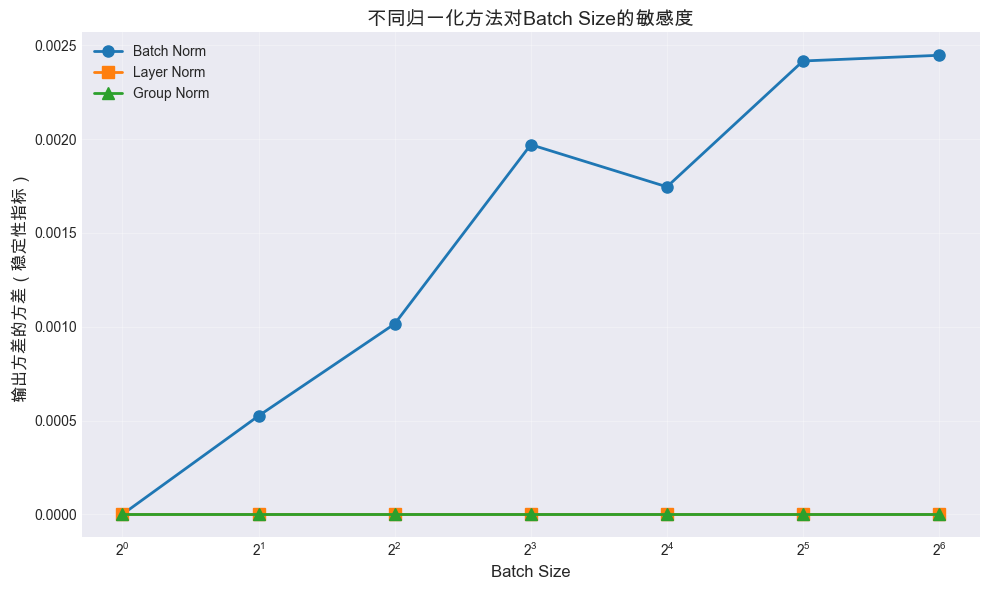


观察：
- Batch Norm: 小batch size时统计量不稳定
- Layer Norm & Group Norm: 不依赖batch size，行为一致


In [5]:
def compare_normalizations():
    """
    对比不同归一化方法对batch size的敏感度
    """
    class BatchNorm:
        """简化的Batch Normalization"""
        def __init__(self, num_features, eps=1e-5):
            self.eps = eps
            self.gamma = np.ones(num_features)
            self.beta = np.zeros(num_features)
        
        def __call__(self, x):
            # x: (N, C, H, W)
            mean = np.mean(x, axis=(0, 2, 3), keepdims=True)
            var = np.var(x, axis=(0, 2, 3), keepdims=True)
            x_norm = (x - mean) / np.sqrt(var + self.eps)
            C = x.shape[1]
            return self.gamma.reshape(1, C, 1, 1) * x_norm + self.beta.reshape(1, C, 1, 1)
    
    # 固定输入数据（不同batch size时取子集）
    np.random.seed(42)
    x_full = np.random.randn(64, 16, 8, 8)  # 完整数据
    
    batch_sizes = [1, 2, 4, 8, 16, 32, 64]
    
    # 存储结果
    bn_vars = []
    ln_vars = []
    gn_vars = []
    
    for bs in batch_sizes:
        x = x_full[:bs]
        
        # Batch Norm
        bn = BatchNorm(16)
        bn_out = bn(x)
        # 计算每个样本的统计量变化
        bn_vars.append(np.var(np.var(bn_out, axis=(1, 2, 3))))
        
        # Layer Norm (适配CNN)
        ln = LayerNorm((16, 8, 8))
        x_for_ln = x
        ln_out = ln(x_for_ln)
        ln_vars.append(np.var(np.var(ln_out, axis=(1, 2, 3))))
        
        # Group Norm
        gn = GroupNorm(4, 16)  # 4组
        gn_out = gn(x)
        gn_vars.append(np.var(np.var(gn_out, axis=(1, 2, 3))))
    
    # 可视化
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(batch_sizes, bn_vars, 'o-', linewidth=2, markersize=8, label='Batch Norm')
    ax.plot(batch_sizes, ln_vars, 's-', linewidth=2, markersize=8, label='Layer Norm')
    ax.plot(batch_sizes, gn_vars, '^-', linewidth=2, markersize=8, label='Group Norm')
    
    ax.set_xlabel('Batch Size', fontsize=12)
    ax.set_ylabel('输出方差的方差（稳定性指标）', fontsize=12)
    ax.set_title('不同归一化方法对Batch Size的敏感度', fontsize=14)
    ax.legend()
    ax.set_xscale('log', base=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n观察：")
    print("- Batch Norm: 小batch size时统计量不稳定")
    print("- Layer Norm & Group Norm: 不依赖batch size，行为一致")

compare_normalizations()

---

## 4. 残差连接（Residual Connection）

### 4.1 深度网络的问题

**退化问题（Degradation Problem）**：
- 理论上，更深的网络应该至少和浅网络一样好
- 实际上，深网络的**训练误差**反而更高
- 这不是过拟合（过拟合是测试误差高、训练误差低）

**原因：**
- 优化困难：梯度消失/爆炸
- 恒等映射难以学习：即使最优解是恒等映射，网络也难以学到

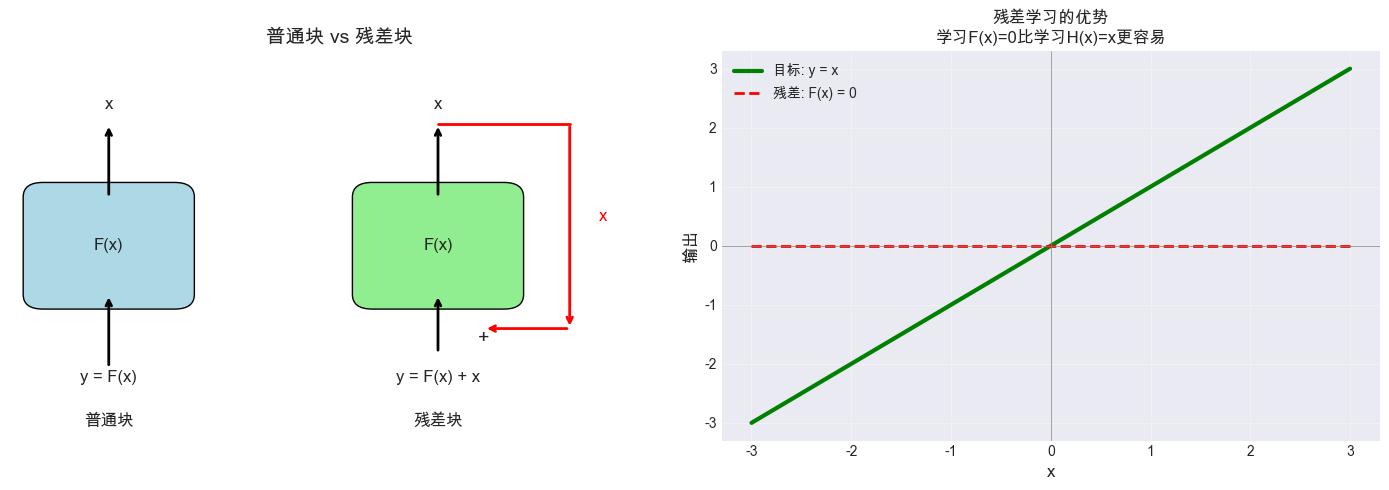


残差连接的关键洞察：
普通块: 学习 H(x) = 目标映射
残差块: 学习 F(x) = H(x) - x，即残差

如果最优映射接近恒等映射:
- 普通块需要学习 H(x) = x（非平凡）
- 残差块只需学习 F(x) = 0（更容易）


In [6]:
def visualize_residual_connection():
    """
    可视化残差连接的原理
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：普通块 vs 残差块
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 8)
    ax1.axis('off')
    ax1.set_title('普通块 vs 残差块', fontsize=14)
    
    # 普通块
    ax1.add_patch(FancyBboxPatch((0.5, 3), 2, 2, boxstyle="round",
                                  facecolor='lightblue', edgecolor='black'))
    ax1.text(1.5, 4, 'F(x)', ha='center', va='center', fontsize=12)
    ax1.annotate('', xy=(1.5, 3), xytext=(1.5, 1.5),
                 arrowprops=dict(arrowstyle='->', lw=2))
    ax1.annotate('', xy=(1.5, 6.5), xytext=(1.5, 5),
                 arrowprops=dict(arrowstyle='->', lw=2))
    ax1.text(1.5, 6.8, 'x', ha='center', fontsize=12)
    ax1.text(1.5, 1.2, 'y = F(x)', ha='center', fontsize=12)
    ax1.text(1.5, 0.3, '普通块', ha='center', fontsize=12, fontweight='bold')
    
    # 残差块
    ax1.add_patch(FancyBboxPatch((5.5, 3), 2, 2, boxstyle="round",
                                  facecolor='lightgreen', edgecolor='black'))
    ax1.text(6.5, 4, 'F(x)', ha='center', va='center', fontsize=12)
    ax1.annotate('', xy=(6.5, 3), xytext=(6.5, 1.8),
                 arrowprops=dict(arrowstyle='->', lw=2))
    ax1.annotate('', xy=(6.5, 6.5), xytext=(6.5, 5),
                 arrowprops=dict(arrowstyle='->', lw=2))
    # 跳跃连接
    ax1.annotate('', xy=(8.5, 2.3), xytext=(8.5, 6.5),
                 arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    ax1.annotate('', xy=(7.2, 2.3), xytext=(8.5, 2.3),
                 arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    ax1.plot([6.5, 8.5], [6.5, 6.5], 'r-', lw=2)
    ax1.text(9, 4.5, 'x', ha='center', fontsize=12, color='red')
    ax1.text(7.2, 2, '+', ha='center', fontsize=14, fontweight='bold')
    ax1.text(6.5, 6.8, 'x', ha='center', fontsize=12)
    ax1.text(6.5, 1.2, 'y = F(x) + x', ha='center', fontsize=12)
    ax1.text(6.5, 0.3, '残差块', ha='center', fontsize=12, fontweight='bold')
    
    # 右图：学习恒等映射的难度
    ax2 = axes[1]
    
    x = np.linspace(-3, 3, 100)
    
    # 目标：恒等映射 y = x
    ax2.plot(x, x, 'g-', linewidth=3, label='目标: y = x')
    
    # 普通网络需要学习的: H(x) = x
    # 残差网络需要学习的: F(x) = 0
    ax2.plot(x, np.zeros_like(x), 'r--', linewidth=2, label='残差: F(x) = 0')
    
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax2.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('输出', fontsize=12)
    ax2.set_title('残差学习的优势\n学习F(x)=0比学习H(x)=x更容易', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n残差连接的关键洞察：")
    print("普通块: 学习 H(x) = 目标映射")
    print("残差块: 学习 F(x) = H(x) - x，即残差")
    print("\n如果最优映射接近恒等映射:")
    print("- 普通块需要学习 H(x) = x（非平凡）")
    print("- 残差块只需学习 F(x) = 0（更容易）")

visualize_residual_connection()

### 4.2 残差块实现

残差连接对梯度流的影响


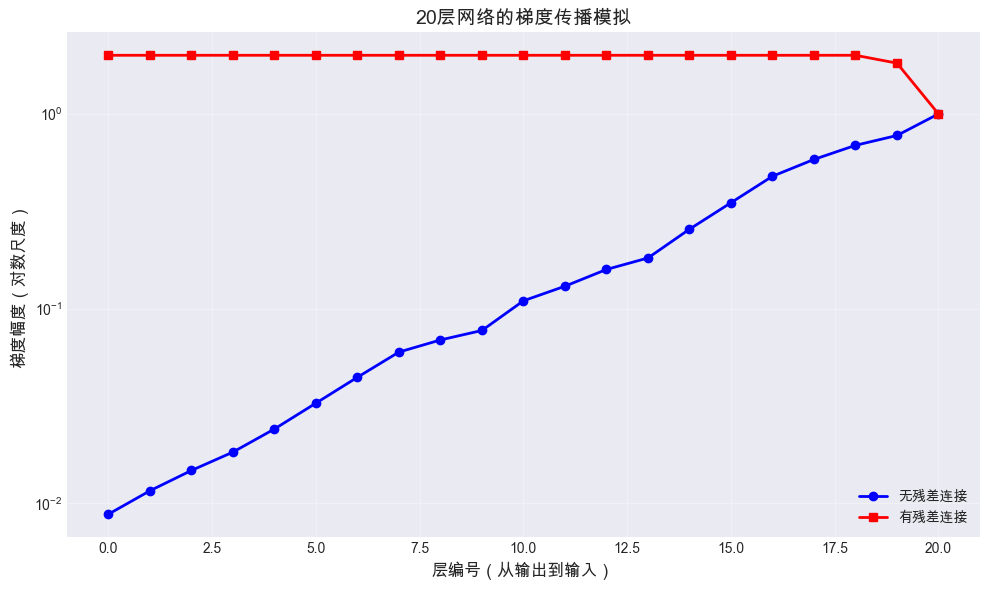


无残差连接：最深层梯度 = 1.00e+00
有残差连接：最深层梯度 = 1.00e+00

残差连接让梯度可以'跳过'层直接传播！


In [7]:
class ResidualBlock:
    """
    残差块 - 从零实现
    
    结构: y = F(x) + x
    
    其中F(x)通常是:
        Conv -> BN -> ReLU -> Conv -> BN
    
    关键点:
        - 跳跃连接让梯度可以直接传播
        - 即使F(x)的梯度很小，x的梯度仍然可以传播
    """
    
    def __init__(self, in_features, hidden_features=None):
        """
        初始化残差块（简化版，使用全连接层）
        
        参数:
            in_features: int，输入特征数
            hidden_features: int，隐藏层特征数（默认与输入相同）
        """
        if hidden_features is None:
            hidden_features = in_features
        
        self.in_features = in_features
        self.hidden_features = hidden_features
        
        # 第一层: Linear -> ReLU
        self.W1 = np.random.randn(in_features, hidden_features) * np.sqrt(2.0 / in_features)
        self.b1 = np.zeros(hidden_features)
        
        # 第二层: Linear（注意输出维度必须与输入相同才能相加）
        self.W2 = np.random.randn(hidden_features, in_features) * np.sqrt(2.0 / hidden_features)
        self.b2 = np.zeros(in_features)
        
        # 层归一化
        self.ln1 = LayerNorm(hidden_features)
        self.ln2 = LayerNorm(in_features)
        
        # 缓存
        self.cache = None
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def forward(self, x):
        """
        前向传播: y = F(x) + x
        
        F(x) = LN(W2 @ ReLU(LN(W1 @ x + b1)) + b2)
        """
        # 保存输入用于跳跃连接
        identity = x
        
        # 第一层
        z1 = x @ self.W1 + self.b1
        z1_norm = self.ln1(z1)
        a1 = self.relu(z1_norm)
        
        # 第二层
        z2 = a1 @ self.W2 + self.b2
        z2_norm = self.ln2(z2)
        
        # 残差连接
        out = z2_norm + identity
        
        self.cache = (x, z1, z1_norm, a1, z2, z2_norm)
        
        return out
    
    def __call__(self, x):
        return self.forward(x)


# 演示残差连接对梯度的影响
def demonstrate_residual_gradient():
    """
    演示残差连接如何改善梯度流
    """
    print("=" * 60)
    print("残差连接对梯度流的影响")
    print("=" * 60)
    
    np.random.seed(42)
    
    # 构建深层网络（有/无残差连接）
    n_layers = 20
    n_features = 32
    
    # 模拟无残差连接的梯度传播
    def simulate_plain_gradients():
        grad = 1.0
        grads = [grad]
        for _ in range(n_layers):
            # 假设每层的梯度乘以一个<1的因子（tanh的导数）
            scale = np.random.uniform(0.7, 0.9)
            grad *= scale
            grads.append(grad)
        return grads[::-1]
    
    # 模拟有残差连接的梯度传播
    def simulate_residual_gradients():
        grad = 1.0
        grads = [grad]
        for _ in range(n_layers):
            # 残差连接: grad_out = grad_F + grad_identity
            # grad_identity = 1 (直接传播)
            # grad_F = scale * grad (通过F(x)传播)
            scale = np.random.uniform(0.7, 0.9)
            grad_f = scale * grad
            grad = grad_f + 1.0 * grad  # 这里简化了，实际是grad += grad_identity
            grads.append(min(grad, 2.0))  # 限制最大值
        return grads[::-1]
    
    plain_grads = simulate_plain_gradients()
    residual_grads = simulate_residual_gradients()
    
    # 可视化
    fig, ax = plt.subplots(figsize=(10, 6))
    
    layers = range(n_layers + 1)
    ax.semilogy(layers, plain_grads, 'b-o', linewidth=2, markersize=6, 
                 label='无残差连接')
    ax.semilogy(layers, residual_grads, 'r-s', linewidth=2, markersize=6, 
                 label='有残差连接')
    
    ax.set_xlabel('层编号（从输出到输入）', fontsize=12)
    ax.set_ylabel('梯度幅度（对数尺度）', fontsize=12)
    ax.set_title(f'{n_layers}层网络的梯度传播模拟', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n无残差连接：最深层梯度 = {plain_grads[-1]:.2e}")
    print(f"有残差连接：最深层梯度 = {residual_grads[-1]:.2e}")
    print("\n残差连接让梯度可以'跳过'层直接传播！")

demonstrate_residual_gradient()

---

## 5. DenseNet密集连接

### 5.1 DenseNet原理

DenseNet将残差连接的思想推向极致：**每一层都与之前所有层连接**。

$$x_l = H_l([x_0, x_1, ..., x_{l-1}])$$

其中$[\cdot]$表示特征拼接（concatenation）。

**优势：**
1. 特征复用：所有层都可以直接访问原始特征
2. 参数高效：不需要重新学习已有特征
3. 梯度流更强：每层都有到输出的直接路径

In [ ]:
class DenseBlock:
    """
    DenseNet的Dense Block - 从零实现
    
    论文: "Densely Connected Convolutional Networks" (Huang et al., 2017)
    
    结构:
        每一层的输入是之前所有层输出的拼接
        x_l = H_l([x_0, x_1, ..., x_{l-1}])
    
    关键概念:
        - Growth Rate (k): 每层新增的特征数
        - 第l层的输入通道数: k_0 + (l-1) * k
    """
    
    def __init__(self, in_features, growth_rate, n_layers):
        """
        初始化Dense Block
        
        参数:
            in_features: int，输入特征数
            growth_rate: int，每层新增的特征数
            n_layers: int，块内层数
        """
        self.growth_rate = growth_rate
        self.n_layers = n_layers
        
        # 初始化每层的权重
        self.layers = []
        current_features = in_features
        
        for i in range(n_layers):
            # 每层: BN -> ReLU -> Conv(1x1) -> BN -> ReLU -> Conv(3x3)
            # 简化为: Linear -> ReLU
            W = np.random.randn(current_features, growth_rate) * np.sqrt(2.0 / current_features)
            b = np.zeros(growth_rate)
            self.layers.append((W, b))
            
            # 下一层的输入包含之前所有层的输出
            current_features += growth_rate
        
        self.out_features = current_features
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: numpy数组, shape (batch, in_features)
        
        返回:
            拼接后的输出, shape (batch, in_features + n_layers * growth_rate)
        """
        features = [x]  # 存储所有层的输出
        
        for W, b in self.layers:
            # 拼接之前所有层的输出作为输入
            concat_features = np.concatenate(features, axis=-1)
            
            # 线性变换 + ReLU
            out = np.maximum(0, concat_features @ W + b)
            
            # 保存输出
            features.append(out)
        
        # 返回所有特征的拼接
        return np.concatenate(features, axis=-1)
    
    def __call__(self, x):
        return self.forward(x)


# 测试Dense Block
def test_dense_block():
    print("=" * 60)
    print("DenseNet Dense Block 测试")
    print("=" * 60)
    
    # 参数
    in_features = 16
    growth_rate = 8
    n_layers = 4
    batch_size = 2
    
    # 创建Dense Block
    db = DenseBlock(in_features, growth_rate, n_layers)
    
    # 测试输入
    x = np.random.randn(batch_size, in_features)
    out = db(x)
    
    expected_out_features = in_features + n_layers * growth_rate
    
    print(f"\n输入形状: {x.shape}")
    print(f"输出形状: {out.shape}")
    print(f"\n配置:")
    print(f"  输入特征: {in_features}")
    print(f"  Growth Rate: {growth_rate}")
    print(f"  层数: {n_layers}")
    print(f"  期望输出特征: {in_features} + {n_layers} × {growth_rate} = {expected_out_features}")
    print(f"  实际输出特征: {out.shape[1]}")

test_dense_block()

In [ ]:
def visualize_dense_connection():
    """
    可视化DenseNet的连接模式
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 左图：ResNet连接模式
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('ResNet连接模式\n(跳跃连接)', fontsize=14)
    
    # 绘制4个层
    layers_y = [8, 6, 4, 2]
    for i, y in enumerate(layers_y):
        ax1.add_patch(FancyBboxPatch((3, y-0.4), 4, 0.8, boxstyle="round",
                                      facecolor='lightblue', edgecolor='black'))
        ax1.text(5, y, f'Layer {i+1}', ha='center', va='center', fontsize=10)
    
    # ResNet跳跃连接
    for i in range(len(layers_y) - 1):
        # 主路径
        ax1.annotate('', xy=(5, layers_y[i+1]+0.4), xytext=(5, layers_y[i]-0.4),
                     arrowprops=dict(arrowstyle='->', lw=2))
        # 跳跃连接（每两层跳跃一次）
        if i % 2 == 0 and i + 2 < len(layers_y):
            ax1.annotate('', xy=(7.5, layers_y[i+2]+0.4), xytext=(7.5, layers_y[i]-0.4),
                         arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    
    # 右图：DenseNet连接模式
    ax2 = axes[1]
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('DenseNet连接模式\n(密集连接)', fontsize=14)
    
    # 绘制4个层
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink']
    for i, y in enumerate(layers_y):
        ax2.add_patch(FancyBboxPatch((3, y-0.4), 4, 0.8, boxstyle="round",
                                      facecolor=colors[i], edgecolor='black'))
        ax2.text(5, y, f'Layer {i+1}', ha='center', va='center', fontsize=10)
    
    # DenseNet密集连接
    line_colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
    color_idx = 0
    for i in range(len(layers_y)):
        for j in range(i + 1, len(layers_y)):
            # 从层i到层j的连接
            offset = (j - i) * 0.3
            ax2.annotate('', xy=(7 + offset, layers_y[j]+0.4), 
                         xytext=(7 + offset, layers_y[i]-0.4),
                         arrowprops=dict(arrowstyle='->', lw=1.5, 
                                        color=line_colors[color_idx % len(line_colors)],
                                        alpha=0.7))
            color_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    print("\nResNet vs DenseNet:")
    print("- ResNet: 跳跃连接，特征相加 (x + F(x))")
    print("- DenseNet: 密集连接，特征拼接 ([x, F1(x), F2(x), ...])")
    print("\nDenseNet优势:")
    print("- 特征复用更充分")
    print("- 参数更少（不需要学习重复特征）")
    print("- 梯度流更强（每层都有到输出的直接路径）")

visualize_dense_connection()

---

## 6. One Cycle学习率策略

### 6.1 One Cycle Policy原理

One Cycle Policy是一种学习率调度策略：

1. **预热阶段**：学习率从低值逐渐增加到最大值
2. **退火阶段**：学习率从最大值逐渐降低到很小的值

**优势：**
- 更快的收敛
- 更好的泛化
- 可以使用更大的学习率

In [ ]:
class OneCycleLR:
    """
    One Cycle学习率调度器 - 从零实现
    
    论文: "Super-Convergence: Very Fast Training of Neural Networks 
           Using Large Learning Rates" (Smith & Topin, 2018)
    
    核心思想:
        1. 预热: 学习率从 max_lr / div_factor 增加到 max_lr
        2. 退火: 学习率从 max_lr 降低到 max_lr / final_div_factor
    
    配合动量调度:
        - 学习率高时，动量低（更aggressive探索）
        - 学习率低时，动量高（更稳定收敛）
    """
    
    def __init__(self, max_lr, total_steps, 
                 pct_start=0.3, div_factor=25, final_div_factor=1e4,
                 anneal_strategy='cos'):
        """
        初始化One Cycle调度器
        
        参数:
            max_lr: float，最大学习率
            total_steps: int，总训练步数
            pct_start: float，预热阶段占比（默认30%）
            div_factor: float，初始学习率 = max_lr / div_factor
            final_div_factor: float，最终学习率 = max_lr / final_div_factor
            anneal_strategy: str，'cos'或'linear'
        """
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.anneal_strategy = anneal_strategy
        
        # 计算关键值
        self.initial_lr = max_lr / div_factor
        self.final_lr = max_lr / final_div_factor
        self.warmup_steps = int(total_steps * pct_start)
        
        self.current_step = 0
    
    def get_lr(self):
        """
        获取当前学习率
        """
        if self.current_step < self.warmup_steps:
            # 预热阶段：线性增加
            pct = self.current_step / self.warmup_steps
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * pct
        else:
            # 退火阶段
            pct = (self.current_step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            
            if self.anneal_strategy == 'cos':
                # 余弦退火
                lr = self.final_lr + (self.max_lr - self.final_lr) * (1 + np.cos(np.pi * pct)) / 2
            else:
                # 线性退火
                lr = self.max_lr - (self.max_lr - self.final_lr) * pct
        
        return lr
    
    def step(self):
        """
        更新步数
        """
        self.current_step += 1
    
    def get_schedule(self):
        """
        获取完整的学习率调度
        """
        lrs = []
        for step in range(self.total_steps):
            self.current_step = step
            lrs.append(self.get_lr())
        self.current_step = 0
        return lrs


# 可视化One Cycle
def visualize_one_cycle():
    """
    可视化One Cycle学习率调度
    """
    total_steps = 1000
    max_lr = 0.1
    
    # 创建不同配置的调度器
    configs = [
        {'pct_start': 0.3, 'anneal_strategy': 'cos', 'label': 'One Cycle (cos, 30% warmup)'},
        {'pct_start': 0.3, 'anneal_strategy': 'linear', 'label': 'One Cycle (linear, 30% warmup)'},
        {'pct_start': 0.1, 'anneal_strategy': 'cos', 'label': 'One Cycle (cos, 10% warmup)'},
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：学习率调度对比
    ax1 = axes[0]
    
    for config in configs:
        scheduler = OneCycleLR(max_lr, total_steps, 
                               pct_start=config['pct_start'],
                               anneal_strategy=config['anneal_strategy'])
        lrs = scheduler.get_schedule()
        ax1.plot(lrs, label=config['label'], linewidth=2)
    
    # 添加常规调度对比
    constant_lr = [max_lr / 10] * total_steps
    ax1.plot(constant_lr, '--', label='常量学习率', linewidth=2, alpha=0.7)
    
    ax1.set_xlabel('训练步数', fontsize=12)
    ax1.set_ylabel('学习率', fontsize=12)
    ax1.set_title('One Cycle学习率调度', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 右图：与其他调度方法对比
    ax2 = axes[1]
    
    # One Cycle
    oc_scheduler = OneCycleLR(max_lr, total_steps)
    ax2.plot(oc_scheduler.get_schedule(), label='One Cycle', linewidth=2)
    
    # Step Decay
    step_lrs = []
    lr = max_lr / 10
    for step in range(total_steps):
        if step in [300, 600, 800]:
            lr *= 0.1
        step_lrs.append(lr)
    ax2.plot(step_lrs, label='Step Decay', linewidth=2)
    
    # Cosine Annealing
    cos_lrs = [max_lr / 10 * (1 + np.cos(np.pi * s / total_steps)) / 2 
               for s in range(total_steps)]
    ax2.plot(cos_lrs, label='Cosine Annealing', linewidth=2)
    
    ax2.set_xlabel('训练步数', fontsize=12)
    ax2.set_ylabel('学习率', fontsize=12)
    ax2.set_title('不同学习率调度方法对比', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nOne Cycle Policy的关键点：")
    print("1. 预热阶段使用较低的学习率，让模型稳定")
    print("2. 中间阶段使用高学习率，加速学习")
    print("3. 退火阶段降低学习率，精细调整")
    print("\n与传统方法相比，可以使用更大的最大学习率！")

visualize_one_cycle()

---

## 7. 总结与最佳实践

### 7.1 归一化方法选择

| 场景 | 推荐方法 |
|------|----------|
| 大batch CNN | Batch Norm |
| 小batch CNN | Group Norm |
| Transformer/RNN | Layer Norm |
| 风格迁移 | Instance Norm |

### 7.2 残差连接的应用

1. 任何深度超过10层的网络都建议使用残差连接
2. Pre-norm（LayerNorm在前）通常比Post-norm更稳定
3. DenseNet在参数效率上更优，但内存占用更大

### 7.3 学习率调度建议

1. One Cycle Policy适合快速训练
2. 如果不确定，从较小的学习率开始
3. 使用学习率finder找到合适的最大学习率

---

## 8. 练习题

### 练习1：实现Instance Normalization

参考Group Norm的实现，实现Instance Normalization（G=C的特殊情况）。

### 练习2：比较Pre-norm和Post-norm

在一个简单的Transformer块中，比较Pre-norm和Post-norm的训练稳定性。

### 练习3（挑战）：实现完整的ResNet块

实现包含卷积层的完整ResNet块，包括处理维度不匹配的投影连接。

In [ ]:
# 练习答案区域

def exercise_1_instance_norm():
    """
    练习1: 实现Instance Normalization
    """
    class InstanceNorm:
        def __init__(self, num_channels, eps=1e-5):
            self.eps = eps
            self.gamma = np.ones(num_channels)
            self.beta = np.zeros(num_channels)
        
        def __call__(self, x):
            # x: (N, C, H, W)
            # 在每个(N, C)对的(H, W)上归一化
            mean = np.mean(x, axis=(2, 3), keepdims=True)
            var = np.var(x, axis=(2, 3), keepdims=True)
            x_norm = (x - mean) / np.sqrt(var + self.eps)
            C = x.shape[1]
            return self.gamma.reshape(1, C, 1, 1) * x_norm + self.beta.reshape(1, C, 1, 1)
    
    # 测试
    x = np.random.randn(2, 4, 8, 8)
    inst_norm = InstanceNorm(4)
    out = inst_norm(x)
    
    print("Instance Normalization 测试:")
    print(f"  输入形状: {x.shape}")
    print(f"  输出形状: {out.shape}")
    # 验证：每个(样本,通道)的空间维度应该归一化
    print(f"  样本0,通道0的均值: {np.mean(out[0, 0]):.6f}")
    print(f"  样本0,通道0的方差: {np.var(out[0, 0]):.6f}")

exercise_1_instance_norm()

---

## 参考资料

1. **Layer Norm**: Ba et al., "Layer Normalization" (2016)
2. **Group Norm**: Wu & He, "Group Normalization" (ECCV 2018)
3. **ResNet**: He et al., "Deep Residual Learning for Image Recognition" (CVPR 2016)
4. **DenseNet**: Huang et al., "Densely Connected Convolutional Networks" (CVPR 2017)
5. **One Cycle**: Smith & Topin, "Super-Convergence" (2018)

---

**恭喜完成神经网络模块的补充学习！**